In [1]:
#ridge

In [1]:
!pip install numpy pandas scikit-learn matplotlib seaborn plotly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = pd.read_csv('Exp_Mn_Mw_Value.txt', sep='\t')
print("Dataset shape:", dataset.shape)
print("\nDataset info:")
print(dataset.info())
print("\nFirst 5 rows:")
print(dataset.head())
print("\nStatistical summary:")
print(dataset.describe())

Dataset shape: (25, 7)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Run                        25 non-null     int64  
 1   Factor A                   25 non-null     int64  
 2   Factor B                   25 non-null     int64  
 3   Factor C                   25 non-null     int64  
 4   Factor D                   25 non-null     int64  
 5   Response 1 (Experimental)  25 non-null     float64
 6   Response 2 (Experimental)  25 non-null     float64
dtypes: float64(2), int64(5)
memory usage: 1.5 KB
None

First 5 rows:
   Run  Factor A  Factor B  Factor C  Factor D  Response 1 (Experimental)  \
0    1       110         7        50        10                    1127.19   
1    2        85        13        50        10                    1024.97   
2    3       101         1       500        60         

In [4]:
# Separate features and targets
X = dataset.iloc[:, 1:5].values  
y = dataset.iloc[:, 5:7].values  # Responses Mn, Mw

feature_names = ['Factor_A','Factor_B','Factor_C','Factor_D']
target_names = ['Response_Mn', 'Response_Mw']

X_df = pd.DataFrame(X, columns=feature_names)
y_df = pd.DataFrame(y, columns=target_names)

print("Features shape:", X_df.shape)
print("Targets shape:", y_df.shape)

Features shape: (25, 4)
Targets shape: (25, 2)


Potential outliers in Factor_C: 2 points

=== CORRELATION ANALYSIS ===


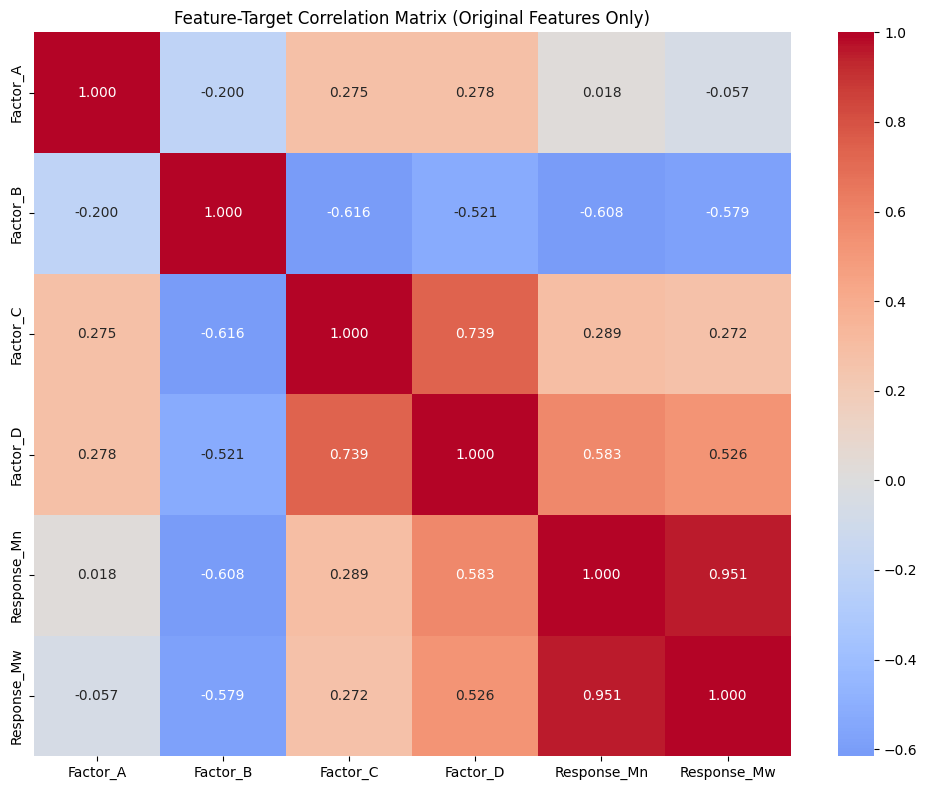

Feature correlation matrix:
          Factor_A  Factor_B  Factor_C  Factor_D
Factor_A  1.000000 -0.199737  0.275302  0.277574
Factor_B -0.199737  1.000000 -0.615965 -0.521326
Factor_C  0.275302 -0.615965  1.000000  0.738576
Factor_D  0.277574 -0.521326  0.738576  1.000000


In [5]:
for col in X_df.columns:
    Q1 = X_df[col].quantile(0.25)
    Q3 = X_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_df[(X_df[col] < lower_bound) | (X_df[col] > upper_bound)]
    if len(outliers) > 0:
        print(f"Potential outliers in {col}: {len(outliers)} points")

# Correlation analysis
print("\n=== CORRELATION ANALYSIS ===")
plt.figure(figsize=(10, 8))
correlation_matrix = pd.concat([X_df, y_df], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Feature-Target Correlation Matrix (Original Features Only)')
plt.tight_layout()
plt.show()

# Check multicollinearity
print("Feature correlation matrix:")
feature_corr = X_df.corr()
print(feature_corr)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size=0.3, shuffle=True, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training set shape: (17, 4)
Test set shape: (8, 4)
Training samples: 17
Test samples: 8


In [7]:
#zscore
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
def evaluate_model_cv(model, X_train, X_test, y_train, y_test, model_name, target_idx, target_name):
    """Conservative model evaluation with cross-validation"""
    print(f"\n--- {model_name} for {target_name} ---")
    
    # Use Leave-One-Out CV for small dataset
    loo_cv = LeaveOneOut()
    cv_scores = cross_val_score(model, X_train, y_train.iloc[:, target_idx], 
                               cv=loo_cv, scoring='r2')
    
    print(f"Leave-One-Out CV R² scores: {cv_scores}")
    print(f"Mean CV R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    # Fit model and evaluate on test set
    model.fit(X_train, y_train.iloc[:, target_idx])
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training metrics
    train_mse = mean_squared_error(y_train.iloc[:, target_idx], y_train_pred)
    train_mae = mean_absolute_error(y_train.iloc[:, target_idx], y_train_pred)
    train_r2 = r2_score(y_train.iloc[:, target_idx], y_train_pred)
    
    # Test metrics
    test_mse = mean_squared_error(y_test.iloc[:, target_idx], y_test_pred)
    test_mae = mean_absolute_error(y_test.iloc[:, target_idx], y_test_pred)
    test_r2 = r2_score(y_test.iloc[:, target_idx], y_test_pred)
    
    print(f"Training   - MSE: {train_mse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")
    print(f"Test       - MSE: {test_mse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}")
    
    # Check for overfitting
    r2_diff = train_r2 - test_r2
    if r2_diff > 0.2:
        print(f"Possible overfitting detected (R² diff: {r2_diff:.4f})")
    elif test_r2 < 0:
        print(f" Model performs worse than baseline (negative R²)")
    else:
        print(f" Model shows reasonable performance")
    
    return model, y_test_pred, {
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores),
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mse': test_mse,
        'test_mae': test_mae
    }

In [9]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut

In [10]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=0.1)': Ridge(alpha=0.1),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=5.0)': Ridge(alpha=5.0),
    'Ridge (α=10.0)': Ridge(alpha=10.0),
    'Ridge (α=50.0)': Ridge(alpha=50.0),
    'Ridge (α=100.0)': Ridge(alpha=100.0),
    'Lasso (α=1.0)': Lasso(alpha=1.0),
    'Lasso (α=5.0)': Lasso(alpha=5.0)
}

results = {}

for target_idx, target_name in enumerate(target_names):
    print(f"EVALUATING MODELS FOR {target_name}")
    
    results[target_name] = {}
    
    for model_name, model in models.items():
        trained_model, predictions, metrics = evaluate_model_cv(
            model, X_train_scaled, X_test_scaled, y_train, y_test, 
            model_name, target_idx, target_name
        )
        results[target_name][model_name] = {
            'model': trained_model,
            'predictions': predictions,
            'metrics': metrics
        }

EVALUATING MODELS FOR Response_Mn

--- Linear Regression for Response_Mn ---
Leave-One-Out CV R² scores: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Mean CV R²: nan ± nan
Training   - MSE: 154543.78, MAE: 332.74, R²: 0.8345
Test       - MSE: 1108951.20, MAE: 825.20, R²: -0.5364
Possible overfitting detected (R² diff: 1.3709)

--- Ridge (α=0.1) for Response_Mn ---
Leave-One-Out CV R² scores: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Mean CV R²: nan ± nan
Training   - MSE: 154875.58, MAE: 333.31, R²: 0.8342
Test       - MSE: 1071418.00, MAE: 807.76, R²: -0.4844
Possible overfitting detected (R² diff: 1.3186)

--- Ridge (α=1.0) for Response_Mn ---
Leave-One-Out CV R² scores: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Mean CV R²: nan ± nan
Training   - MSE: 176879.27, MAE: 337.72, R²: 0.8106
Test       - MSE: 828283.26, MAE: 679.67, R²: -0.1475
Possible overfitting detected (R² diff: 0.9582)

--- Ridge (α=5.0)